In [1]:
%matplotlib widget

In [20]:
%matplotlib notebook

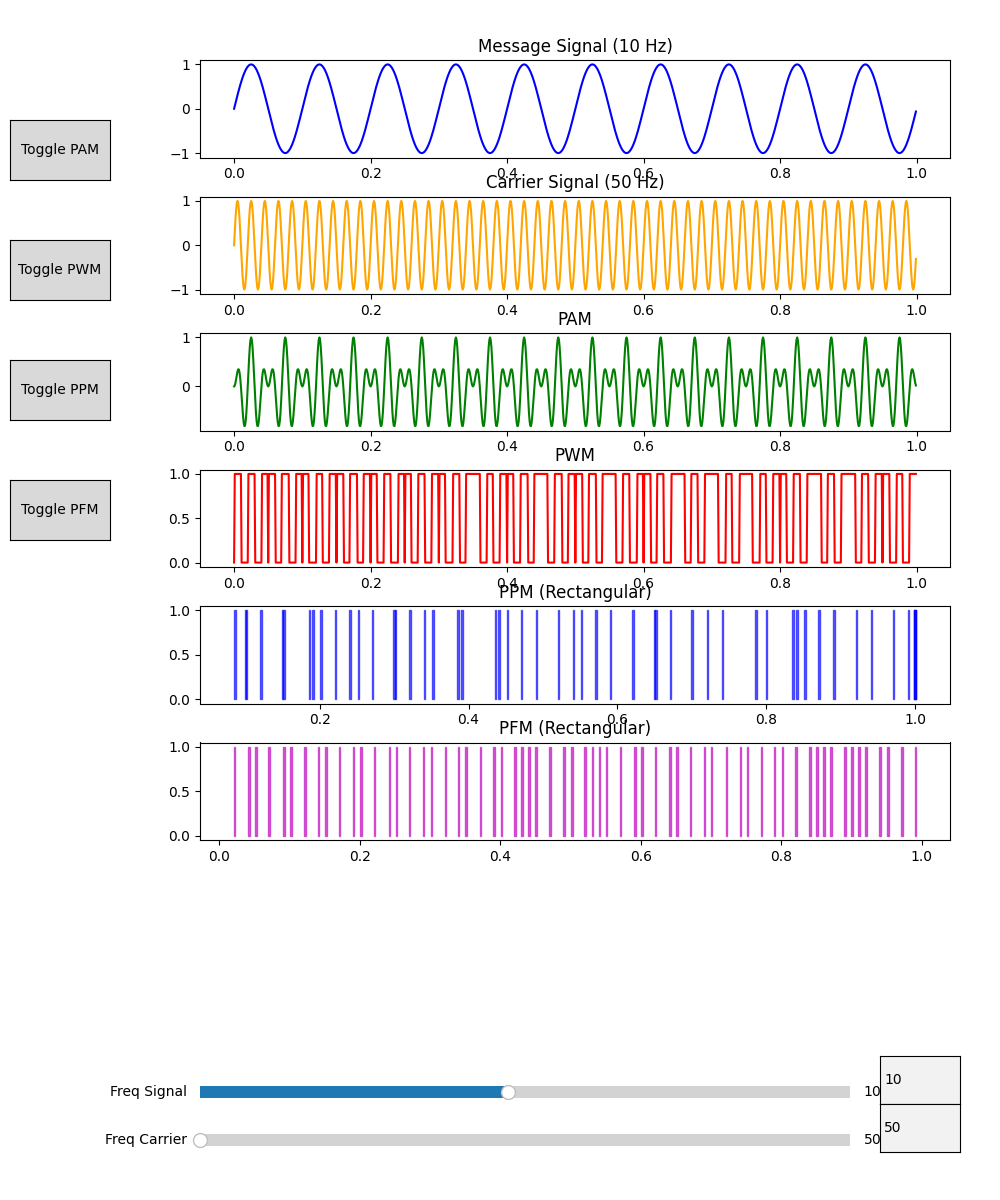

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, TextBox

# Parameters
fs = 1000  # Sampling frequency
T = 1      # Signal duration
t = np.linspace(0, T, int(fs * T), endpoint=False)  # Time axis

# Global variables
f_signal = 10
f_carrier = 50

# Modulation states
toggle_pam, toggle_pwm, toggle_ppm, toggle_pfm = True, True, True, True

# Create figure
fig, axs = plt.subplots(6, 1, figsize=(10, 12))
ax_message, ax_carrier, ax_pam, ax_pwm, ax_ppm, ax_pfm = axs
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.3, top=0.95, hspace=0.4)

# Create sliders
ax_slider_f_signal = plt.axes([0.2, 0.08, 0.65, 0.02])
slider_f_signal = Slider(ax_slider_f_signal, 'Freq Signal', 1, 20, valinit=f_signal, valstep=1)

ax_slider_f_carrier = plt.axes([0.2, 0.04, 0.65, 0.02])
slider_f_carrier = Slider(ax_slider_f_carrier, 'Freq Carrier', 50, 500, valinit=f_carrier, valstep=10)

# Create textboxes for frequency display
ax_text_f_signal = plt.axes([0.88, 0.08, 0.08, 0.04])
text_f_signal = TextBox(ax_text_f_signal, '', initial=str(f_signal))

ax_text_f_carrier = plt.axes([0.88, 0.04, 0.08, 0.04])
text_f_carrier = TextBox(ax_text_f_carrier, '', initial=str(f_carrier))

# Buttons for modulations
buttons = {}
button_labels = ['PAM', 'PWM', 'PPM', 'PFM']
toggle_vars = ['toggle_pam', 'toggle_pwm', 'toggle_ppm', 'toggle_pfm']
for i, label in enumerate(button_labels):
    ax_btn = plt.axes([0.01, 0.85 - i * 0.1, 0.1, 0.05])
    buttons[label] = Button(ax_btn, f'Toggle {label}')

# Update function
def update(val):
    global f_signal, f_carrier

    # Update frequencies
    f_signal = slider_f_signal.val
    f_carrier = slider_f_carrier.val

    # Synchronize textboxes with sliders
    text_f_signal.set_val(f"{int(f_signal)}")
    text_f_carrier.set_val(f"{int(f_carrier)}")

    # Recalculate signals
    message_signal = np.sin(2 * np.pi * f_signal * t)
    carrier_signal = np.sin(2 * np.pi * f_carrier * t)
    modulated_signal = message_signal * carrier_signal

    # Modulations
    pam_signal = modulated_signal if toggle_pam else np.zeros_like(t)
    pwm_signal = np.where(modulated_signal > 0, 1, 0) if toggle_pwm else np.zeros_like(t)

    # PPM Modulation
    ppm_signal = np.zeros_like(t)
    ppm_width = 1 / (10 * f_carrier)  
    ppm_positions = []
    if toggle_ppm:
        for i in range(1, len(t) - 1):
            if modulated_signal[i - 1] < 0 and modulated_signal[i] >= 0:
                shift = int((modulated_signal[i] + 1) * (fs // (2 * f_signal)))
                new_index = min(i + shift, len(t) - 1)
                ppm_positions.append(t[new_index])

    # PFM Modulation
    pfm_signal = np.zeros_like(t)
    pfm_width = 1 / (10 * f_carrier)
    pfm_positions = []
    if toggle_pfm:
        last_pulse_time = 0
        min_pulse_interval = 0.01
        for i in range(len(t)):
            if modulated_signal[i] > 0 and (t[i] - last_pulse_time) > min_pulse_interval:
                pfm_positions.append(t[i])
                last_pulse_time = t[i]

    # Update plots
    ax_message.clear()
    ax_message.plot(t, message_signal, color='blue')
    ax_message.set_title(f'Message Signal ({int(f_signal)} Hz)')

    ax_carrier.clear()
    ax_carrier.plot(t, carrier_signal, color='orange')
    ax_carrier.set_title(f'Carrier Signal ({int(f_carrier)} Hz)')

    ax_pam.clear()
    ax_pam.plot(t, pam_signal, color='green')
    ax_pam.set_title('PAM')

    ax_pwm.clear()
    ax_pwm.plot(t, pwm_signal, color='red')
    ax_pwm.set_title('PWM')

    ax_ppm.clear()
    for pos in ppm_positions:
        ax_ppm.fill_between([pos, pos + ppm_width], 0, 1, color='b', alpha=0.6)
    ax_ppm.set_title('PPM (Rectangular)')

    ax_pfm.clear()
    for pos in pfm_positions:
        ax_pfm.fill_between([pos, pos + pfm_width], 0, 1, color='m', alpha=0.6)
    ax_pfm.set_title('PFM (Rectangular)')

    fig.canvas.draw_idle()  

# Toggle modulation functions
def toggle_modulation(mod):
    def toggle(event):
        globals()[mod] = not globals()[mod]
        update(None)
    return toggle

for i, label in enumerate(button_labels):
    buttons[label].on_clicked(toggle_modulation(toggle_vars[i]))

# Textbox input functions
def set_f_signal(text):
    try:
        value = float(text)
        slider_f_signal.set_val(value)  
    except ValueError:
        pass  

def set_f_carrier(text):
    try:
        value = float(text)
        slider_f_carrier.set_val(value)  
    except ValueError:
        pass  

# Connect sliders and textboxes
slider_f_signal.on_changed(update)
slider_f_carrier.on_changed(update)
text_f_signal.on_submit(set_f_signal)
text_f_carrier.on_submit(set_f_carrier)

# Initial update
update(None)
plt.show()